/var/folders/sb/krtdqwds3lg0vghh1l417sr00000gn/T/ipykernel_6280/1370942649.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.fillna(0, inplace=True)


Linear Regression - MAE: 1.49
Linear Regression - MSE: 689.64
Linear Regression - RMSE: 26.26
Linear Regression - R² Score: 1.00
Random Forest Regressor - R² Score: 1.00
Logistic Regression - Accuracy: 99.78%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2054
           1       0.99      1.00      1.00       685

    accuracy                           1.00      2739
   macro avg       1.00      1.00      1.00      2739
weighted avg       1.00      1.00      1.00      2739

Gradient Boosting Classifier - Accuracy: 99.63%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2054
           1       0.99      0.99      0.99       685

    accuracy                           1.00      2739
   macro avg       1.00      0.99      1.00      2739
weighted avg       1.00      1.00      1.00      2739



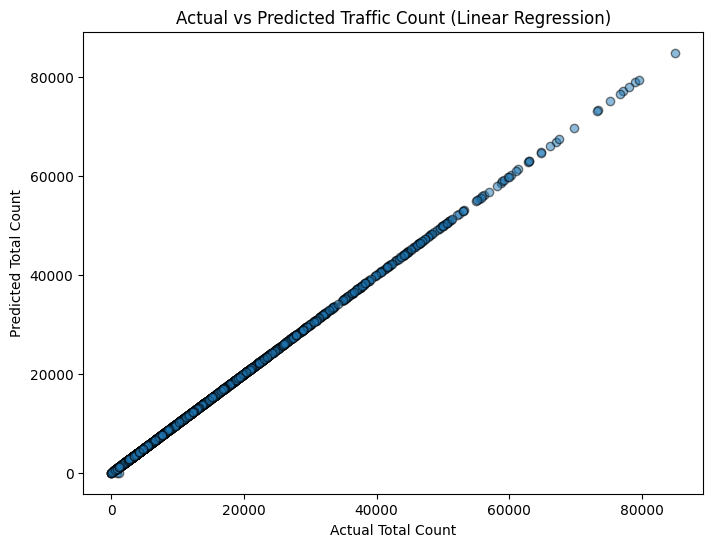

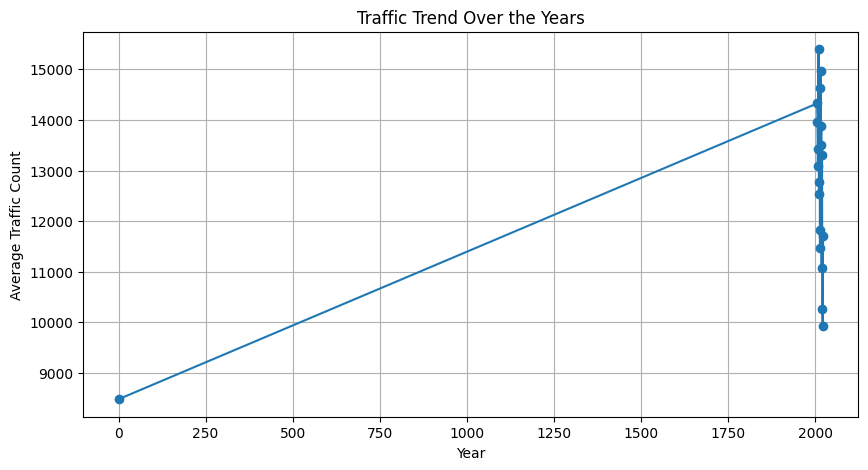

/var/folders/sb/krtdqwds3lg0vghh1l417sr00000gn/T/ipykernel_6280/1370942649.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[df['day_of_week'] == i]["total_count"] for i in range(7)], labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])


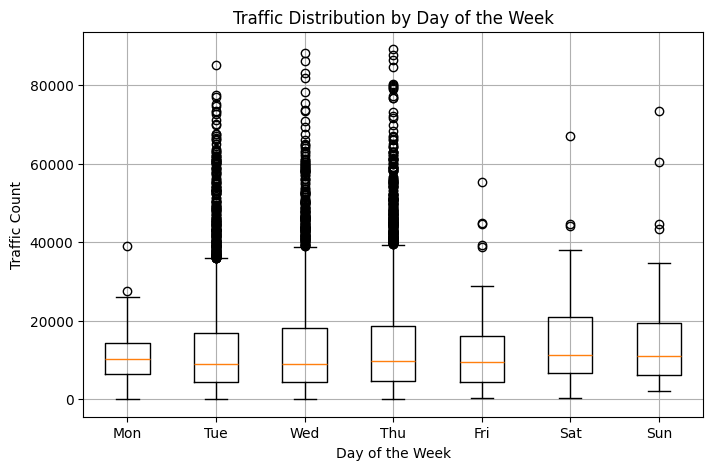

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Load the dataset
file_path = "traffic_counts_datasd.csv"  # Ensure this file is in the same directory
df = pd.read_csv(file_path)

# Convert date to datetime format and extract features
df["date_count"] = pd.to_datetime(df["date_count"], errors="coerce")
df["year"] = df["date_count"].dt.year
df["month"] = df["date_count"].dt.month
df["day_of_week"] = df["date_count"].dt.dayofweek

# Fill missing values
df.fillna(0, inplace=True)

# Convert numeric columns properly
numeric_cols = ["northbound_count", "southbound_count", "eastbound_count", "westbound_count", "total_count"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# Check if street and cross_street columns exist
categorical_cols = []
if "street" in df.columns:
    categorical_cols.append("street")
if "cross_street" in df.columns:
    categorical_cols.append("cross_street")

# Select features and target
features = ["northbound_count", "southbound_count", "eastbound_count", "westbound_count", "year", "month", "day_of_week"] + categorical_cols
target = "total_count"

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=pd.qcut(df[target], q=4, duplicates='drop'))

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["northbound_count", "southbound_count", "eastbound_count", "westbound_count", "year", "month", "day_of_week"]),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols) if categorical_cols else ("cat", "passthrough", [])
    ]
)

# Train a Linear Regression model
lr_model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])
lr_model.fit(X_train, y_train)

# Train a Random Forest Regressor
rf_model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))])
rf_model.fit(X_train, y_train)

# Predict and evaluate Linear Regression
y_pred_lr = lr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae:.2f}")
print(f"Linear Regression - MSE: {mse:.2f}")
print(f"Linear Regression - RMSE: {rmse:.2f}")
print(f"Linear Regression - R² Score: {r2:.2f}")

# Predict and evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regressor - R² Score: {r2_rf:.2f}")

# Train a Logistic Regression model
y_train_class = (y_train > y_train.quantile(0.75)).astype(int)
y_test_class = (y_test > y_test.quantile(0.75)).astype(int)

logreg = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(solver='liblinear', max_iter=200))])
logreg.fit(X_train, y_train_class)

# Train a Gradient Boosting Classifier
gb_classifier = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))])
gb_classifier.fit(X_train, y_train_class)

# Predict and evaluate Logistic Regression
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test_class, y_pred_logreg)
print(f"Logistic Regression - Accuracy: {accuracy_logreg:.2%}")
print(classification_report(y_test_class, y_pred_logreg))

# Predict and evaluate Gradient Boosting Classifier
y_pred_gb = gb_classifier.predict(X_test)
accuracy_gb = accuracy_score(y_test_class, y_pred_gb)
print(f"Gradient Boosting Classifier - Accuracy: {accuracy_gb:.2%}")
print(classification_report(y_test_class, y_pred_gb))

# Visualize actual vs predicted traffic counts
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, edgecolors='k')
plt.xlabel("Actual Total Count")
plt.ylabel("Predicted Total Count")
plt.title("Actual vs Predicted Traffic Count (Linear Regression)")
plt.show()

# Traffic trend analysis by year
plt.figure(figsize=(10,5))
plt.plot(df.groupby("year")["total_count"].mean(), marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Average Traffic Count")
plt.title("Traffic Trend Over the Years")
plt.grid(True)
plt.show()

# Traffic distribution by day of the week
plt.figure(figsize=(8,5))
plt.boxplot([df[df['day_of_week'] == i]["total_count"] for i in range(7)], labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.xlabel("Day of the Week")
plt.ylabel("Traffic Count")
plt.title("Traffic Distribution by Day of the Week")
plt.grid(True)
plt.show()







